## Forecasting Water Levels in Cape Town Dam Reservoirs  

### The data is from Theewaterskloof Dam that is located next to Sonderend River near Villiersdorp, Western Cape, South Africa. It is the largest dam in the Western Cape Water Supply System with a capacity of 480 million cubic metres, about 41% of the water storage capacity available to Cape Town, which has a population of over 4 million people.

### The Data starts from 01/01/2012 and ends on 19/04/2018. 

### The goal is to forecast future dam levels to develop an accuracte model for predicting "day-zero", when dam levels drop below 5%. To aid in this prediction, our goal is to add a variable of rainfall to this model. 

### First goal is to get a general prediction going without the added variable of weather. 

In [1]:
# Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.preprocessing import Imputer
from sklearn.neighbors import NearestNeighbors 
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

sns.set_style('whitegrid')
%matplotlib inline


C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('input/THEEWATERSKLOOF.csv')
#df.columns = ['date', 'Dam Level']
df.dropna(axis=0, inplace=True)
df.head()


,Date,Level
0,01-Jan-12,74.5
1,02-Jan-12,74.3
2,03-Jan-12,74.0
3,04-Jan-12,73.7
4,05-Jan-12,73.1


In [3]:
df['Date'] = pd.to_datetime(df['Date']) # Change Date column to datatype:'datetime' ; Possibly bug derived in this phase
df.index = df['Date'] # Make it index
del df['Date']
df.head()  

,Level
Date,
2012-01-01,74.5
2012-01-02,74.3
2012-01-03,74.0
2012-01-04,73.7
2012-01-05,73.1


In [4]:
df[df.index.duplicated()]  
df = df[~df.index.duplicated()] # Detect and remove duplicates in the index; produces errors otherwise



In [5]:
goog= df.copy()

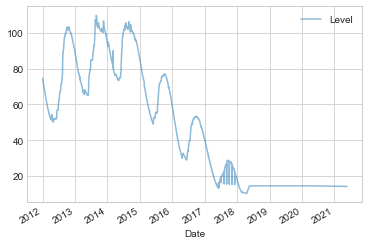

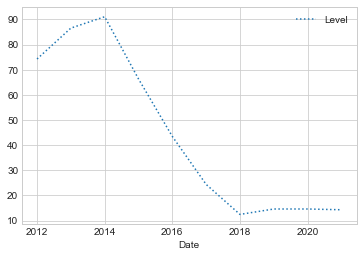

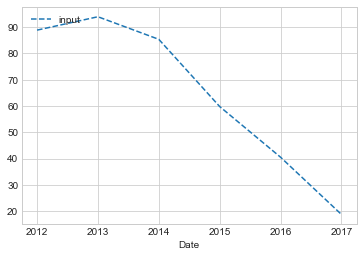

In [6]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

plt.show()

### Error on the first graph when it plots until 2021 and skews all the results down below

In [7]:

y= df.copy()

In [8]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

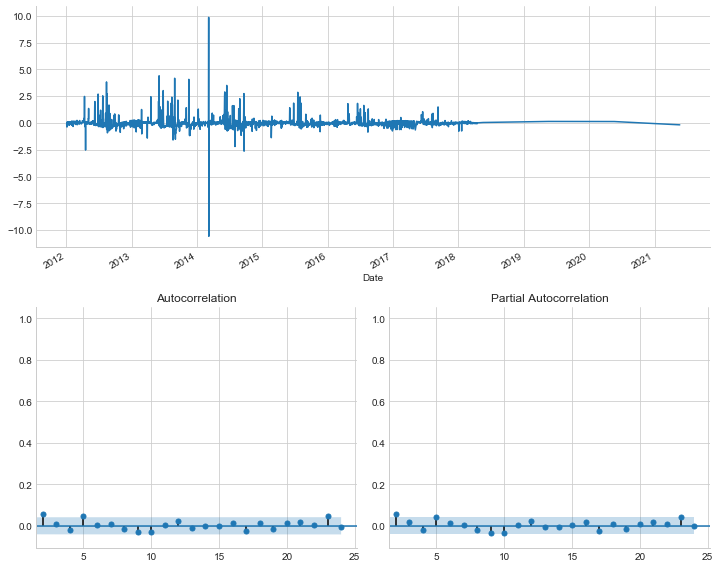

In [9]:
mod = smt.SARIMAX(df, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=24);

In [10]:
X = (pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])
       .dropna())
X.head()

,y,L1,L2,L3,L4,L5
,Level,Level,Level,Level,Level,Level
Date,,,,,,
2012-01-06,72.9,73.1,73.7,74.0,74.3,74.5
2012-01-07,72.6,72.9,73.1,73.7,74.0,74.3
2012-01-08,72.3,72.6,72.9,73.1,73.7,74.0
2012-01-09,72.0,72.3,72.6,72.9,73.1,73.7
2012-01-10,71.6,72.0,72.3,72.6,72.9,73.1


In [11]:
mod_lagged = smf.ols('y ~ trend + L1 + L2 + L3 + L4 + L5',
                     data=X.assign(trend=np.arange(len(X))))
res_lagged = mod_lagged.fit()
res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.049e+06
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        20:54:46   Log-Likelihood:                -1820.4
No. Observations:                2285   AIC:                             3655.
Df Residuals:                    2278   BIC:                             3695.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0986      0.062      1.590      0.112      -0.023       0.220
trend       -5.34e-05   2.52e-05     -2.115      0.035      -0.000   -3.89e-06
L1             1.0559      0.021     50.577      0.000       1.015       1.097
L2             0.1165      0.030      3.830      0.000       0.057       0.176
L3            -0.0457      0.030     -1.499      0.134      -0.105       0.014
L4            -0.0454      0.030     -1.493      0.136      -0.105       0.014
L5            -0.0821      0.021     -3.933      0.000      -0.123      -0.041
==============================================================================
Omnibus:                     1367.881   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1514988.839
Skew:                           1.322   Prob(JB):                         0.00
Kurtosis:                     129.116   Cond. No.                     7.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

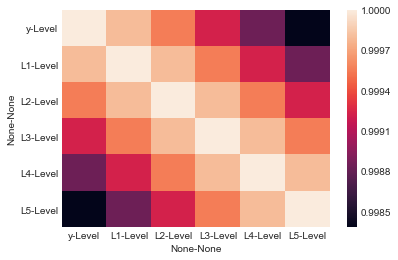

In [12]:
sns.heatmap(X.corr());
plt.show()

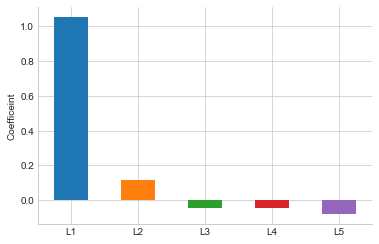

In [13]:
ax = res_lagged.params.drop(['Intercept', 'trend']).plot.bar(rot=0)
plt.ylabel('Coefficeint')
sns.despine()

In [14]:
miss = df.isnull().sum()/len(df)
print(type(miss)) # <class 'pandas.core.series.Series'>

<class 'pandas.core.series.Series'>


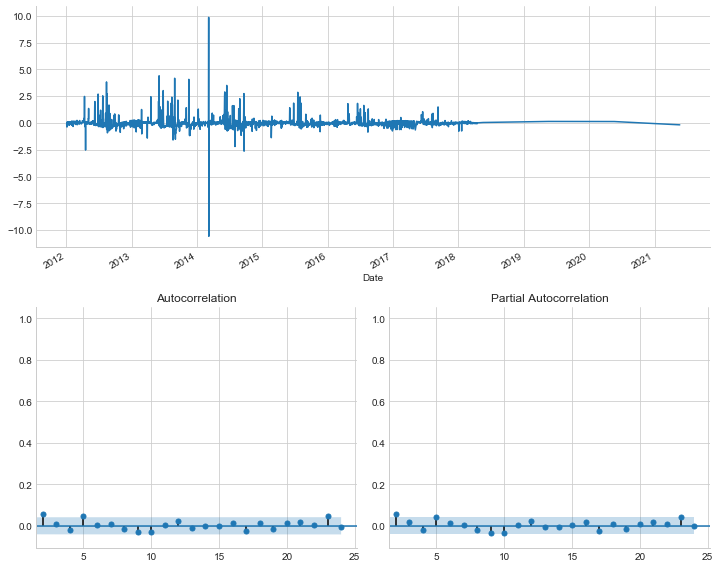

In [15]:
mod = smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=24);

In [16]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Level   No. Observations:                 2290
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1781.324
Date:                Tue, 01 May 2018   AIC                           3570.648
Time:                        20:54:50   BIC                           3593.593
Sample:                    01-01-2012   HQIC                          3579.015
                         - 04-19-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    7.42e-05      0.001      0.069      0.945      -0.002       0.002
ar.L1          0.9985      0.003    376.582      0.000       0.993       1.004
ma.L1         -0.9360      0.005   -193.340      0.000      -0.945      -0.926
sigma2         0.2773      0.002    169.709      0.000       0.274       0.281
===================================================================================
Ljung-Box (Q):                       44.45   Jarque-Bera (JB):           1739729.78
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       138.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
mod_seasonal = smt.SARIMAX(y, trend='c',
                           order=(1, 1, 2), seasonal_order=(0, 1, 2, 12),
                           simple_differencing=False)
res_seasonal = mod_seasonal.fit()

C:\Users\omistaja\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [18]:
res_seasonal.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Level   No. Observations:                 2290
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -1856.391
Date:                            Tue, 01 May 2018   AIC                           3726.782
Time:                                    20:55:48   BIC                           3766.936
Sample:                                01-01-2012   HQIC                          3741.425
                                     - 04-19-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.000     -0.961      0.336      -0.001       0.000
ar.L1          0.6122      0.061      9.956      0.000       0.492       0.733
ma.L1         -0.4882      0.060     -8.089      0.000      -0.607      -0.370
ma.L2          0.0685      0.020      3.496      0.000       0.030       0.107
ma.S.L12      -0.8987      0.016    -56.143      0.000      -0.930      -0.867
ma.S.L24      -0.0880      0.015     -6.028      0.000      -0.117      -0.059
sigma2         0.2822      0.003     89.926      0.000       0.276       0.288
===================================================================================
Ljung-Box (Q):                      255.08   Jarque-Bera (JB):           1847013.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                       142.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

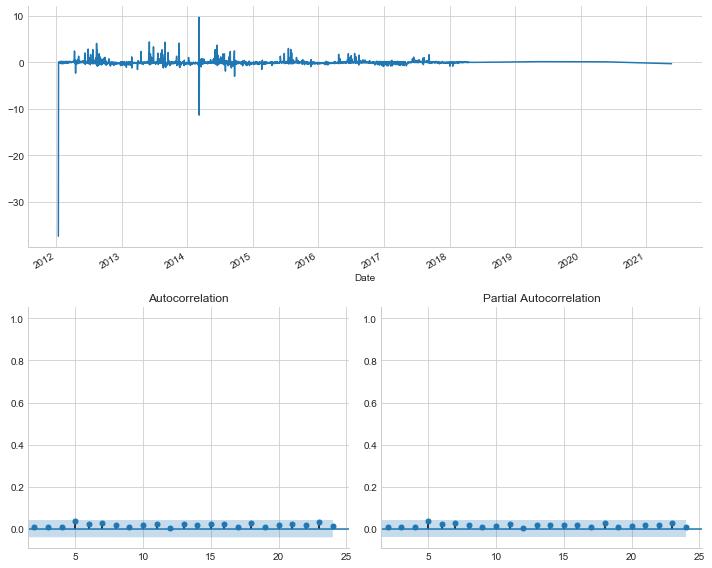

In [19]:
tsplot(res_seasonal.resid[12:], lags=24);


In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
df.head()

,Level
Date,
2012-01-01,74.5
2012-01-02,74.3
2012-01-03,74.0
2012-01-04,73.7
2012-01-05,73.1


In [31]:
pred = res_seasonal.get_prediction(start='2016-12-01')
pred_ci = pred.conf_int()

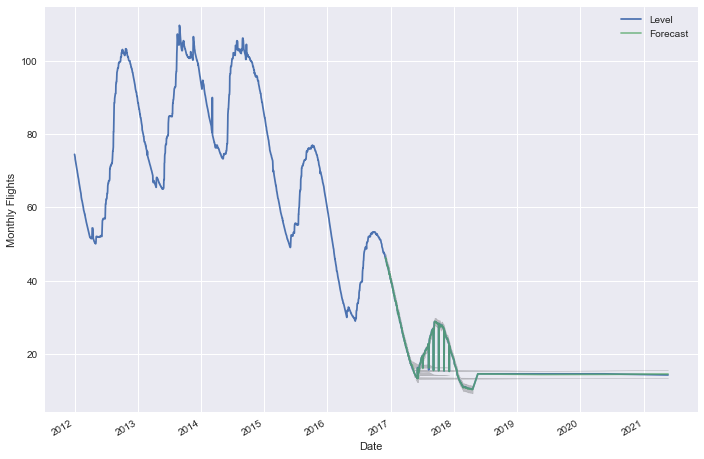

In [32]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel("Monthly Flights")
plt.legend()
sns.despine()

In [38]:
pred_dy = res_seasonal.get_prediction(start='2012-01-01', dynamic='2012-01-01')
pred_dy_ci = pred_dy.conf_int()

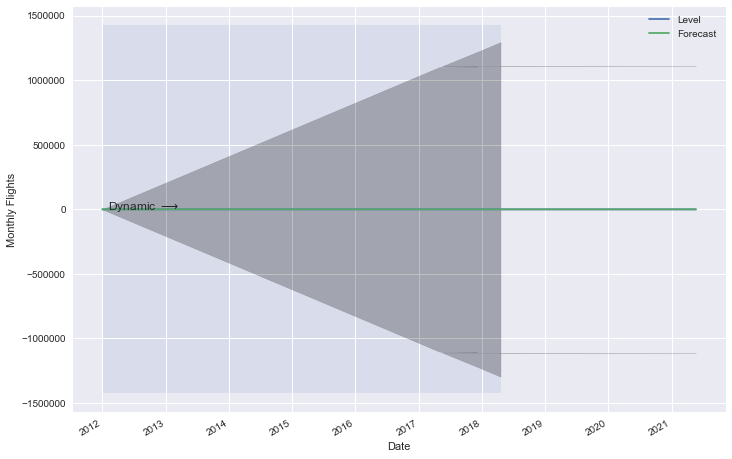

In [40]:
ax = y.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly Flights")

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2012-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2012-02-01'), 550))

plt.legend()
sns.despine()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
df['new'], df['value'], test_size=0.33, random_state=42)

In [ ]:
#dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))


In [ ]:
sm.stats.durbin_watson(df)


In [ ]:
df.plot(figsize=(12,8))
plt.show()